# Rewards Analytics and Distribution Dashboard
This goal of this notebook is to offer an easy way to process the outputs of the praise and sourcecred reward systems, perform an analysis of the results and calculate the token reward distribution. It uses mock data and should be considered a work-in-progress. 

### Imports
First, we import the relevant libraries, get the Data and set how many tokens we want to distribute

In [2]:
from ipyfilechooser import FileChooser

import os
import sys
import inspect

import pandas as pd 
import numpy as np 
import analytics_toolbox as tb

import holoviews as hv
from holoviews import opts
import plotly.graph_objects as go
import plotly.express as px

import base64
from IPython.display import HTML

fc_praise = FileChooser('.')
fc_sourcecred = FileChooser('.')
fc_rewardboard = FileChooser('.')

print("== Please choose the Praise CSV file == ")
display(fc_praise)
print("== Please choose the Sourcecred CSV file == ")
display(fc_sourcecred)
print("== Please choose the Rewardboard address list CSV file == ")
display(fc_rewardboard)

== Please choose the Praise CSV file == 


FileChooser(path='/Users/kristoferlund/Documents/tec-praise-quantifications', filename='', title='', show_hidd…

== Please choose the Sourcecred CSV file == 


FileChooser(path='/Users/kristoferlund/Documents/tec-praise-quantifications', filename='', title='', show_hidd…

== Please choose the Rewardboard address list CSV file == 


FileChooser(path='/Users/kristoferlund/Documents/tec-praise-quantifications', filename='', title='', show_hidd…

Now that we have selected the files, we can import them for processing. We can also set the total amount of tokens we want to distribute this period. We also set the name we want our output file to have.

Tip: Now that the file paths are set, you can safely click on "Cell > Run all below" from here on the menu bar to execute everything :) 

### Parameters

Set the total amount of tokens we want to distribute this period. We also set the name we want our output file to have.

In [3]:

NUMBER_OF_PRAISE_REWARD_TOKENS_TO_DISTRIBUTE = 1950
NUMBER_OF_SOURCECRED_REWARD_TOKENS_TO_DISTRIBUTE = 1950
NUMBER_OF_REWARD_TOKENS_FOR_QUANTIFIERS = 500
NUMBER_OF_REWARD_TOKENS_FOR_REWARD_BOARD = 100
NUMBER_OF_QUANTIFIERES_PER_PRAISE = 3

OUTPUT_FILENAME = "rewards_round_01"

In [5]:
PRAISE_DATA_PATH = fc_praise.selected
SOURCECRED_DATA_PATH = fc_sourcecred.selected
REWARD_BOARD_ADDRESSES_PATH = fc_rewardboard.selected

praise_data = pd.read_csv(PRAISE_DATA_PATH)
sourcecred_data = pd.read_csv(SOURCECRED_DATA_PATH)
rewardboard_addresses = pd.read_csv(REWARD_BOARD_ADDRESSES_PATH)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
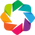

In [6]:
hv.extension('bokeh')

## Reward allocation

### Praise

This method allocates the praise rewards in a very straightforward way: It adds the value of all dished praised together, and then assigns to each user their % of the total.

In [7]:
def calc_praise_rewards(praiseData, tokensToDistribute):
    #we discard all we don't need and and calculate the % worth of each praise
    #slimData = praiseData[['FROM USER ACCOUNT', 'TO USER ACCOUNT', 'FINAL QUANT']].copy()
    totalPraisePoints = praiseData['FINAL QUANT'].sum()

    praiseData['PERCENTAGE'] = praiseData['FINAL QUANT']/totalPraisePoints
    praiseData['TOKEN TO RECEIVE'] = praiseData['PERCENTAGE'] * tokensToDistribute
    return praiseData

praise_distribution = calc_praise_rewards(praise_data.copy(), NUMBER_OF_PRAISE_REWARD_TOKENS_TO_DISTRIBUTE)
#praise_distribution


### SourceCred
We do the same procedure, but with the sourcecred data.

In [8]:
def calc_sourcecred_rewards(sourcecredData, tokensToDistribute):
    #we discard all we don't need and and calculate the % worth of each praise
    slimData = sourcecredData[['IDENTITY', 'AMOUNT']].copy()
    totalGrainPoints = slimData['AMOUNT'].sum()

    slimData['PERCENTAGE'] = slimData['AMOUNT']/totalGrainPoints
    slimData['TOKEN TO RECEIVE'] = slimData['PERCENTAGE'] * tokensToDistribute
    return slimData

sourcecred_distribution = calc_sourcecred_rewards(sourcecred_data.copy(), NUMBER_OF_SOURCECRED_REWARD_TOKENS_TO_DISTRIBUTE)
#sourcecred_distribution.style

## Preparing and combining the Datasets

Now that we have the distributions done, we can combine them into one table.
But before that, we need to prepare the data and clean it a bit. We also use the chance to generate a table which shows us how much praise each user received. We'll use it later in our analysis.

In [9]:
#General Helper func. Puts all the "processing we probably won't need to do later or do differently" in one place
#  -removes the '#' and following from discord names
#  -Some renaming and dropping 
def prepare_praise(praise_data):
    praise_data['TO USER ACCOUNT'] = (praise_data['TO USER ACCOUNT'].str.split('#', 1, expand=False).str[0]).str.lower()
    praise_data.rename(columns = {'TO USER ACCOUNT':'IDENTITY'}, inplace = True)
    processed_praise = praise_data[['IDENTITY', 'PERCENTAGE', 'TOKEN TO RECEIVE']]
    praise_by_user = praise_data[['IDENTITY', 'FINAL QUANT', 'PERCENTAGE', 'TOKEN TO RECEIVE']].groupby(['IDENTITY']).agg('sum').reset_index()
    return processed_praise, praise_by_user

#General Helper func. Puts all the "processing we probably won't need to do later or do differently" in one place
#  -Some renaming and dropping 
#  -changing percentages from 0 - 100 to 0.00-1.00
def prepare_sourcecred(sourcecred_data):
    sourcecred_data.rename(columns = {'%':'PERCENTAGE'}, inplace = True)
    sourcecred_data['IDENTITY'] = sourcecred_data['IDENTITY'].str.lower()
    sourcecred_data['PERCENTAGE'] = sourcecred_data['PERCENTAGE']
    sourcecred_data = sourcecred_data[['IDENTITY', 'PERCENTAGE', 'TOKEN TO RECEIVE']]
    return sourcecred_data


processed_praise, praise_by_user = prepare_praise(praise_distribution.copy())
processed_sourcecred = prepare_sourcecred(sourcecred_distribution.copy())
praise_by_user.sort_values(by=['FINAL QUANT'], ascending=False).style



,IDENTITY,FINAL QUANT,PERCENTAGE,TOKEN TO RECEIVE
22,"griff (💜, 💜)",1010,0.101182,197.305149
40,liviade,953,0.095472,186.170106
48,natesuits,712,0.071328,139.090363
61,sem 🐝,610,0.061110,119.164496
14,divine_comedian,510,0.051092,99.629333
33,karmaticacid,495,0.049589,96.699058
0,acidlazzer,471,0.047185,92.010619
51,nuggan,467,0.046784,91.229213
41,markop,414,0.041475,80.875576
65,suga,272,0.027249,53.135644


Let's also create a table which will let us focus on the quantifiers. It will show us what value each quantifier gave to each single praise item.

In [10]:
def data_by_quantifier(praise_data):
    quant_only = pd.DataFrame()
    praise_data.drop(['DATE', 'TO USER ACCOUNT', 'FROM USER ACCOUNT', 'REASON', 'SOURCE ID', 'SOURCE NAME', 'CORRECTION ADD', 'CORRECTION SUB', 'CORRECTION COMMENT', 'FINAL QUANT'], axis=1, inplace=True)
    for i in range(NUMBER_OF_QUANTIFIERES_PER_PRAISE):
        q_name =  str( 'QUANTIFIER '+ str(i+1) +' USERNAME' )
        q_value = str('SCORE '+str(i+1) )
        buf = praise_data[['ID', q_name , q_value ]].copy()
    
        buf.rename(columns={q_name: 'QUANT_ID', q_value: 'QUANT_VALUE', 'ID':'PRAISE_ID'}, inplace=True)
        #print(buf)
        quant_only = quant_only.append(buf.copy(), ignore_index=True)

    columnsTitles = ['QUANT_ID', 'PRAISE_ID', 'QUANT_VALUE']
    quant_only.sort_values(['QUANT_ID', 'PRAISE_ID'], inplace=True)
    quant_only =  quant_only.reindex(columns=columnsTitles).reset_index(drop=True)
    return quant_only

quantifier_rating_table = data_by_quantifier(praise_data.copy())



Now we are ready to go.

In [11]:
#generates a new table with combined percentages and token rewards
def combine_datasets(praise_data, sourcecred_data):
    
    combined_dataset = processed_praise.append(processed_sourcecred, ignore_index=True)
    combined_dataset = combined_dataset.groupby(['IDENTITY']).agg('sum').reset_index()
    
    #since we just added to percentages
    combined_dataset['PERCENTAGE'] = combined_dataset['PERCENTAGE'] / 2


    return combined_dataset


total_period_rewards =combine_datasets(processed_praise.copy(), processed_sourcecred.copy())

# Results Analysis
Let's dive into some data analysis! We'll use the metrics designed and explained by octopus🐙 for now, starting with:

### Allocation percentages
This table will show us which percentage if the total rewards gets distributed to which top % of users. So "Top 50% -> 0.85" would mean that the top 50% of praisees received 85% of the total rewards 

In [12]:
p_vals = np.array([50,80,90,95,99])
rewards_rp = np.array([tb.resource_percentage(total_period_rewards["TOKEN TO RECEIVE"], p) for p in p_vals])

my_rd_index = [("Top " + str(100 - p) +"%") for p in p_vals]
resource_distribution = pd.DataFrame({"Rewards": rewards_rp}, index = my_rd_index)
resource_distribution

,Rewards
Top 50%,0.935531
Top 20%,0.697605
Top 10%,0.492307
Top 5%,0.344395
Top 1%,0.139879


### Gini coefficient
Next we will look at the Gini coefficient. Note that there is some debate if we want to use this metric at all, since it is usually employed to measure wealth distribution, and not compensation.

In [13]:
p_vals = np.array([0, 50, 80])
rewards_gc = np.array([tb.gini_gt_p(np.array(total_period_rewards["TOKEN TO RECEIVE"]), p) for p in p_vals])

my_index = ["All", "Top 50%", "Top 20%"]
gini_coefs = pd.DataFrame({"Rewards": rewards_gc}, index = my_index)
gini_coefs

,Rewards
All,0.668881
Top 50%,0.462123
Top 20%,0.304492


### Shannon Entropy

[Shannon Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) is a concept from communications theory, which is also used in measuring the diversity of a distribution. The formula for calculating Shannon Entropy among $n$ individuals is
    $$\\sum_{k=1}^n -p_k log_2(p_k),$$
where $p_k$ represents the proportion of the resource that user $k$ received.

Here we compare the actual Shannon Entropy with the maximum possible for the dataset, keeping in mind that a Shannon Entropy of 0 would mean one user holds all the rewards


In [14]:
entropies_df = pd.DataFrame(data = {"Rewards" : tb.calc_shannon_entropies(total_period_rewards["PERCENTAGE"]) }, index = ["Entropy", "Max Entropy", "% of Max"])
entropies_df

,Rewards
Entropy,5.794014
Max Entropy,6.988685
% of Max,0.829056


### Nakamoto Coefficient
Last but not least, the Nakamoto coefficient. The Nakamato Coefficient is defined as the smallest number of accounts who control at least 50% of the resource. Although its significance relates to the prospect of a 51% attack on a network, which may not be relevant in our context, we can still use it as an intuitive measure of how many individuals received the majority of a resource.

In [15]:
ak_coef_IH = tb.nakamoto_coeff(total_period_rewards, "PERCENTAGE")
ak_coef_IH

14

## Praise Data

### Rating distribution
Since praise gets valued on a scale, we can take a look at how often each value of the scale gets assigned by quantifiers.

In [16]:
freq = quantifier_rating_table[['QUANT_VALUE']].value_counts().rename_axis('QUANT_VALUE').reset_index(name='counts').sort_values(by=['QUANT_VALUE'])
freq['QUANT_VALUE'] = freq['QUANT_VALUE'].astype('string')

fig_freq = px.bar(freq, x="QUANT_VALUE", y="counts", labels={"QUANT_VALUE": "Rating","counts": "Number of appearances"}, title="Praise Rating Distribution", width=800, height=300)
fig_freq.show()


### Praise Reward Distribution

We can also take a look at the distribution of the received praise rewards

In [17]:
pr_distribution = praise_by_user[['IDENTITY', 'PERCENTAGE']].sort_values(by=['PERCENTAGE'], ascending=False)

fig_pr_distribution = px.bar(pr_distribution, x='IDENTITY', y='PERCENTAGE', labels={"IDENTITY": "User","PERCENTAGE": "% of total"}, title="Praise Reward Distribution")#.opts(width=800, height=500, title='SourceCred Distribution', xlabel='Value', ylabel='% of Total', xaxis='bare')
fig_pr_distribution.update_xaxes(showticklabels=False)

fig_pr_distribution.show()


### Praise Flows

Now for something more fun: let's surface the top "praise flows" from the data. Thanks to @inventandchill for this awesome visualization! 
On one side we have the top 20 praise givers separately (modifiable by changing the variable n_senders), on the other the top 25 receivers (modifiable by changing the variable n_receivers). The people outside the selection get aggregated into the "REST FROM" and "REST TO" categories.

In [18]:
NUMBER_OF_SENDERS_FLOW = 20 #The left side, the praise senders. X largest ones + one bucket for the rest 
NUMBER_OF_RECEIVERS_FLOW = 25 #The right side, the praise receivers. X largest ones + one bucket for the rest 
praise_flow = tb.prepare_praise_flow(praise_distribution.copy(), n_senders=NUMBER_OF_SENDERS_FLOW, n_receivers=NUMBER_OF_RECEIVERS_FLOW)
#praise_flow

In [30]:
%%opts Sankey (cmap='Category10' edge_color='FROM USER ACCOUNT' edge_line_width=0 node_alpha=1.0)
%%opts Sankey [node_sort=False label_position='outer' bgcolor="snow" node_width=40 node_sort=True ]
%%opts Sankey [width=1000 height=800 title="Praise flow for Batch 1. Sum of Praise. Left - praise sender. Right - praise receiver"]
%%opts Sankey [margin=0 padding=0 show_values=True]

hv.Sankey(praise_flow, kdims=["FROM USER ACCOUNT", "TO USER ACCOUNT"], vdims=["FINAL QUANT"])

:Sankey   [FROM USER ACCOUNT,TO USER ACCOUNT]   (FINAL QUANT)

## SourceCred Data

### SourceCred token Distribution

Next we can see the distribution made by the SourceCred algorithm.

In [20]:

sc_distribution = processed_sourcecred[['IDENTITY', 'PERCENTAGE']].sort_values(by=['PERCENTAGE'], ascending=False)

fig_sc_distribution = px.bar(sc_distribution, x='IDENTITY', y='PERCENTAGE', labels={"IDENTITY": "User","PERCENTAGE": "% of total"}, title="SourceCred Distribution")
fig_sc_distribution.update_xaxes(showticklabels=False)

fig_sc_distribution.show()


## Quantifier Data
Let's take a closer look at each quantifier. In the following step we will use the raw praise data to zoom in on how each quantifier scored the praises:

### Amount of praise quantified
With the above table we can easily see how much praise each quantifier rated.

In [21]:
quant_praise_distribution = quantifier_rating_table['QUANT_ID'].value_counts().reset_index().rename(columns={'index': 'QUANT_ADDRESS', 'QUANT_ID': 'NUMBER_OF_PRAISES'})
#quant_praise_distribution

In [22]:
fig_pie = px.pie(quant_praise_distribution, values='NUMBER_OF_PRAISES', names='QUANT_ADDRESS', title='Amount of praise per quantifier', labels={'NUMBER_OF_PRAISES': 'Praises quant'})
fig_pie.update_layout(showlegend=False)
fig_pie.show()

## Total Token Distribution Visualization and  Export
To send the allocations to the DAO for distribution, we need to put all data together and add the rewards for the reward board and the quantifiers. 

First, we will calculate the rewards for the Quantifiers and the Reward Board. This is fairly straightforward, since we distribute the allocated tokens equally.


In [23]:
quantifier_rewards = pd.DataFrame(quant_praise_distribution['QUANT_ADDRESS'].copy())
quantifier_rewards['TOKEN TO RECEIVE'] = NUMBER_OF_REWARD_TOKENS_FOR_QUANTIFIERS / len(quantifier_rewards.index)
#quantifier_rewards

In [24]:
rewardboard_rewards = pd.DataFrame(rewardboard_addresses)
rewardboard_rewards['TOKEN TO RECEIVE'] = NUMBER_OF_REWARD_TOKENS_FOR_REWARD_BOARD / len(rewardboard_rewards.index)
#rewardboard_rewards

Now we can merge them all into one table and save it, ready for distribution!

In [25]:
def prepare_total_data_chart(praise_rewards, sourcecred_rewards, quantifier_rewards, rewardboard_rewards):
    
    praise_rewards = praise_rewards.copy()[['IDENTITY', 'TOKEN TO RECEIVE']].rename(columns = {'TOKEN TO RECEIVE':'PRAISE_REWARD'})
    sourcecred_rewards = sourcecred_rewards.copy()[['IDENTITY', 'TOKEN TO RECEIVE']].rename(columns = {'TOKEN TO RECEIVE':'SOURCECRED_REWARD'})
    quantifier_rewards.rename(columns = {'QUANT_ADDRESS':'IDENTITY', 'TOKEN TO RECEIVE':'QUANT_REWARD'}, inplace = True)
    rewardboard_rewards.rename(columns = {'ID':'IDENTITY', 'TOKEN TO RECEIVE': 'REWARDBOARD_REWARD'}, inplace = True)
    
    final_allocations = pd.merge(praise_rewards, sourcecred_rewards , on=['IDENTITY','IDENTITY'], how='outer')
    final_allocations = pd.merge(final_allocations, quantifier_rewards , on=['IDENTITY','IDENTITY'], how='outer')
    final_allocations = pd.merge(final_allocations , rewardboard_rewards ,on=['IDENTITY','IDENTITY'],how='outer')
    
    final_allocations.fillna(0, inplace = True)
    final_allocations['TOTAL TO RECEIVE'] = final_allocations['PRAISE_REWARD'] + final_allocations['SOURCECRED_REWARD'] + final_allocations['QUANT_REWARD'] + final_allocations['REWARDBOARD_REWARD']
    final_allocations = final_allocations.sort_values(by= 'TOTAL TO RECEIVE', ascending  = False).reset_index(drop=True)
    return final_allocations

final_token_allocations = prepare_total_data_chart(praise_by_user.copy(), processed_sourcecred.copy(), quantifier_rewards.copy(), rewardboard_rewards.copy())
final_token_allocations.style



,IDENTITY,PRAISE_REWARD,SOURCECRED_REWARD,QUANT_REWARD,REWARDBOARD_REWARD,TOTAL TO RECEIVE
0,0x260a364c0016a6cb724a858384a2f68aa2ad3591,0.000000,285.627602,0.000000,0.000000,285.627602
1,0x308d8013ecd9b1bf4bf8ad738108db7843d5f996,0.000000,259.899104,0.000000,0.000000,259.899104
2,"griff (💜, 💜)",197.305149,0.000000,0.000000,0.000000,197.305149
3,liviade,186.170106,0.000000,0.000000,0.000000,186.170106
4,0x5ca759eba225f3ac4401041e9e663182c3157415,0.000000,155.884428,0.000000,0.000000,155.884428
5,natesuits,139.090363,0.000000,0.000000,0.000000,139.090363
6,sem 🐝,119.164496,0.000000,0.000000,0.000000,119.164496
7,0xd11c3b7caec5d353e07c388fe4b3f5c2774fc986,0.000000,102.363649,0.000000,0.000000,102.363649
8,divine_comedian,99.629333,0.000000,0.000000,0.000000,99.629333
9,karmaticacid,96.699058,0.000000,0.000000,0.000000,96.699058


Let's take a final look at the total distribution. Click on the legend to filter out specific reward sources

In [26]:
fig_final_alloc = px.bar(final_token_allocations, x="IDENTITY", y = ["QUANT_REWARD", "REWARDBOARD_REWARD", "PRAISE_REWARD", "SOURCECRED_REWARD"], title="Rewards received by category", color_discrete_map = {'PRAISE_REWARD': 'blue', 'SOURCECRED_REWARD': 'red', 'QUANT_REWARD':'green', 'REWARDBOARD_REWARD':'yellow'})
fig_final_alloc.update_xaxes(showticklabels=False)
fig_final_alloc.show()


That's it! We can now download the final distribution files and upload them to GitHub for future reference. We want to export 3 different files: <br>
   &emsp;- The final reward allocations, separated by source<br>
    &emsp;- The final reward allocations, in a disperse.app-readable format<br>
   &emsp;- The extended praise data, detailing the how many tokens each single praise netted (for future reference)<br>

In [27]:
def create_download_link(csv, filename, download_title):
    filename = filename
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=download_title,filename=filename)
    return HTML(html)

final_allocation_csv = final_token_allocations.to_csv(index=False)
create_download_link(csv = final_allocation_csv, filename=OUTPUT_FILENAME, download_title = "Download final reward CSV file")

In [28]:
final_alloc_disperse = final_token_allocations[['IDENTITY', 'TOTAL TO RECEIVE']].to_csv(sep=' ', index=False, header=False)
create_download_link(final_alloc_disperse, filename=(OUTPUT_FILENAME+"-disperse"), download_title = "Download disperse.app compatible file")

In [29]:
praise_reward_export = praise_distribution.to_csv(index=False)
create_download_link(praise_reward_export, filename=OUTPUT_FILENAME+"-extendedPraise", download_title = "Download complete praise data")